In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

replay_info = replay_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)
replay_info.head()

Continuous  Continuous_duration  \
Animal ID day epoch ripple_number                                    
cor       1   2     1                   False                0.000   
                    2                   False                0.000   
                    3                   False                0.000   
                    4                    True                0.078   
                    5                   False                0.000   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                0.433000   
                    2                                0.145381   
                    3                                0.253176   
                    4                                0.984090   
                    5                                0.471484   

                                   Continuous_max_time  Continuous_min_time  \
Animal ID day epoch ripple_number                                             
cor       1   2     1                              NaN                  NaN   
                    2                              NaN                  NaN   
                    3                              NaN                  NaN   
                    4                            0.076                  0.0   
                    5                              NaN                  NaN   

                                   Continuous_n_total_spikes  \
Animal ID day epoch ripple_number                              
cor       1   2     1                                    NaN   
                    2                                    NaN   
                    3                                    NaN   
                    4                                  112.0   
                    5                                    NaN   

                                   Continuous_n_unique_spiking  \
Animal ID day epoch ripple_number                                
cor       1   2     1                                      NaN   
                    2                                      NaN   
                    3                                      NaN   
                    4                                      9.0   
                    5                                      NaN   

                                   Continuous_population_rate  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                     NaN   
                    2                                     NaN   
                    3                                     NaN   
                    4                              130.536131   
                    5                                     NaN   

                                   Continuous_replay_distance_from_actual_position  \
Animal ID day epoch ripple_number                                                    
cor       1   2     1                                                          NaN   
                    2                                                          NaN   
                    3                                                          NaN   
                    4                                                    23.952445   
                    5                                                          NaN   

                                   Continuous_replay_distance_from_center_well  \
Animal ID day epoch ripple_number                                                
cor       1   2     1                                                      NaN   
                    2                                                      NaN   
                    3                                                      NaN   
                    4                                                23.952445   
                    5                                                  

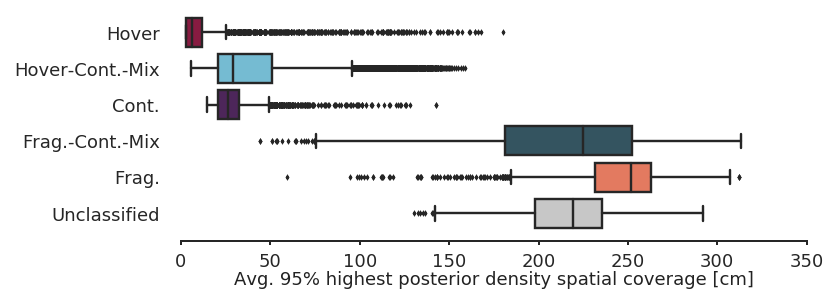

In [4]:
from src.visualization import _plot_category
from src.figure_utilities import ONE_COLUMN, TWO_COLUMN, PAGE_HEIGHT, save_figure

fig, ax = plt.subplots(figsize=(TWO_COLUMN * 0.8, PAGE_HEIGHT // 4))
_plot_category(
    replay_info,
    "spatial_coverage",
    kind="box",
    ax=ax,
    include_unclassified=True,
    saturation=0.7,
    fliersize=1,
)
ax.set_xlabel("Avg. 95% highest posterior density spatial coverage [cm]")
sns.despine(offset=5, left=False)
ax.set_xlim((0, 350))
ax.spines["left"].set_visible(False)
ax.tick_params(
    axis="y", which="both", left=False,
)
save_figure(os.path.join("Figure4", "figure4_spatial_coverage"))

In [5]:
spatially_coherent_spatial_coverage = replay_info.loc[
    :,
    [
        "Hover_spatial_coverage",
        "Hover-Continuous-Mix_spatial_coverage",
        "Continuous_spatial_coverage",
    ],
]

spatially_incoherent_spatial_coverage = replay_info.loc[
    :, ["Fragmented-Continuous-Mix_spatial_coverage", "Fragmented_spatial_coverage",],
]

print(
    f"spatially coherent 95% HPD: {np.nanmedian(spatially_coherent_spatial_coverage):0.0f}, "
    f"spatially incoherent 95% HPD: {np.nanmedian(spatially_incoherent_spatial_coverage):0.0f}"
)

spatially coherent 95% HPD: 24, spatially incoherent 95% HPD: 238


In [6]:
from scipy.stats import mannwhitneyu

mannwhitneyu(
    spatially_coherent_spatial_coverage.values.ravel(),
    spatially_incoherent_spatial_coverage.values.ravel(),
    alternative="greater",
)

MannwhitneyuResult(statistic=2625836402.5, pvalue=0.0)

In [7]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [8]:
2625836402.5 / (
    spatially_coherent_spatial_coverage.values[
        ~np.isnan(spatially_coherent_spatial_coverage.values)
    ].size
    * spatially_incoherent_spatial_coverage.values[
        ~np.isnan(spatially_incoherent_spatial_coverage.values)
    ].size
)

22.71113854847928

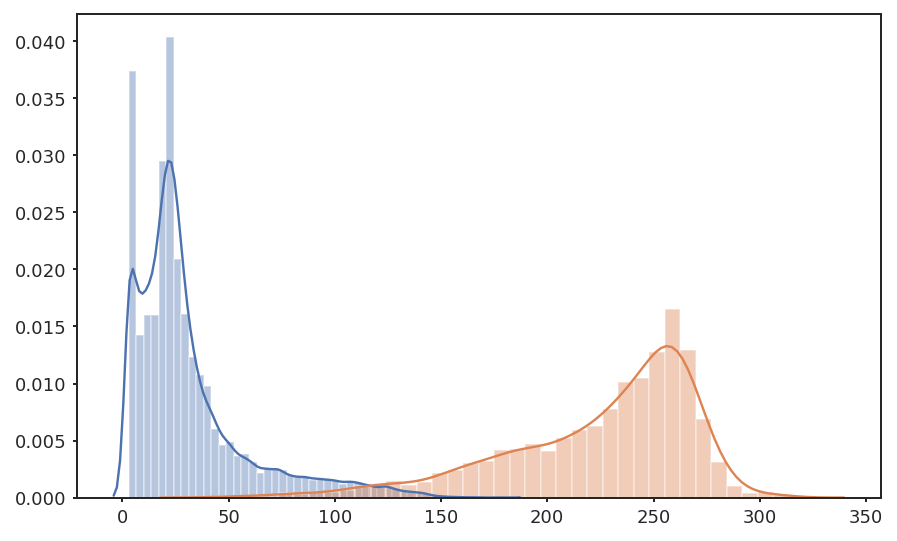

In [9]:
blah = spatially_coherent_spatial_coverage.values.ravel()
sns.distplot(blah[~np.isnan(blah)])
blah = spatially_incoherent_spatial_coverage.values.ravel()
sns.distplot(blah[~np.isnan(blah)])

In [10]:
import copy
import xarray as xr

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)

from src.analysis import highest_posterior_density
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.analysis import get_is_classified, get_probability
from src.figure_utilities import ONE_COLUMN, PAGE_HEIGHT, save_figure
from src.parameters import PROBABILITY_THRESHOLD, STATE_COLORS
from src.visualization import plot_1D_wtrack_landmarks, plot_2D_position_with_color_time
from src.figure4 import plot_clusterless_1D_results_hpd


def plot_ripple_figure_1D(
    epoch_key, ripple_numbers, is_save_figure=True, cmap="bone_r"
):
    if isinstance(ripple_numbers, int):
        ripple_numbers = [ripple_numbers]
    data_type, dim = "clusterless", "1D"
    animal, day, epoch = epoch_key
    data = load_data(epoch_key)

    # Fit
    position = data["position_info"].loc[:, "linear_position"]
    track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

    model_name = os.path.join(
        PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
    )
    classifier = ClusterlessClassifier.load_model(model_name)

    results = xr.open_dataset(
        os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )

    for ripple_number in ripple_numbers:
        plot_clusterless_1D_results_hpd(
            data,
            results.sel(ripple_number=ripple_number).dropna("time", how="all"),
            classifier,
            epoch_key,
            ripple_number,
            cmap=cmap,
            is_save_figure=is_save_figure,
        )

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, inferring correct inbound/outbound from task rules


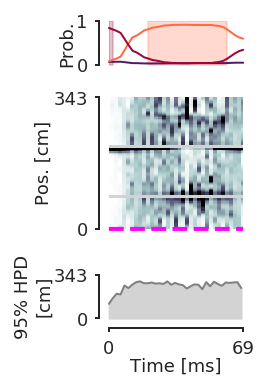

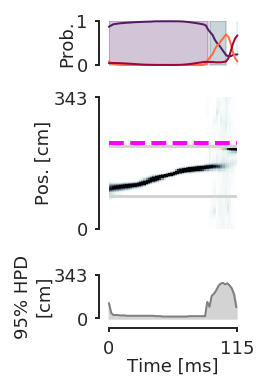

In [12]:
epoch_key = "remy", 35, 2
ripple_numbers = [176, 334]
plot_ripple_figure_1D(epoch_key, ripple_numbers)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, inferring correct inbound/outbound from task rules


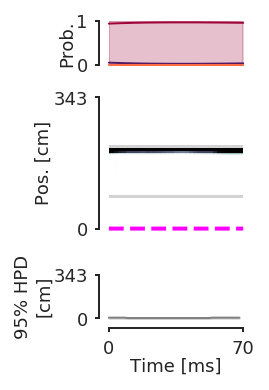

In [13]:
epoch_key = "remy", 37, 4
ripple_numbers = [255]
plot_ripple_figure_1D(epoch_key, ripple_numbers)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, inferring correct inbound/outbound from task rules


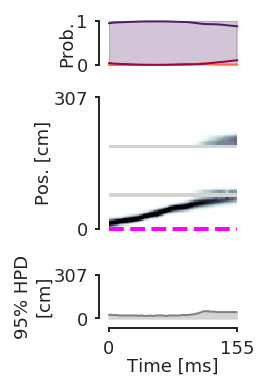

In [14]:
epoch_key = "bon", 6, 4
ripple_numbers = [51]
plot_ripple_figure_1D(epoch_key, ripple_numbers)